In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import gc

In [2]:
def reduce_mem_usage2(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: #numericsのデータ型の範囲内のときに処理を実行. データの最大最小値を元にデータ型を効率的なものに変更
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64) 
    
    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        num_reduction = str(100 * (start_mem - end_mem) / start_mem)
        print(f'Mem. usage decreased to {str(end_mem)[:3]}Mb:  {num_reduction[:2]}% reduction')
    return df

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    dfs = []
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: #numericsのデータ型の範囲内のときに処理を実行. データの最大最小値を元にデータ型を効率的なものに変更
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dfs.append(df[col].astype(np.int8))
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dfs.append(df[col].astype(np.int16))
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dfs.append(df[col].astype(np.int32))
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dfs.append(df[col].astype(np.int64) ) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dfs.append(df[col].astype(np.float16))
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dfs.append(df[col].astype(np.float32))
                else:
                    dfs.append(df[col].astype(np.float64))
        else:
            dfs.append(df[col])
    
    df_out = pd.concat(dfs, axis=1)
    if verbose:
        end_mem = df_out.memory_usage().sum() / 1024**2
        num_reduction = str(100 * (start_mem - end_mem) / start_mem)
        print(f'Mem. usage decreased to {str(end_mem)[:3]}Mb:  {num_reduction[:2]}% reduction')
    return df_out

In [4]:
def calc_df_mem(df_input):
    return df_input.memory_usage().sum()

def small_test(df_input):
    print("org mem", calc_df_mem(df_input))
    print("reduced mem", calc_df_mem(df_input.astype(np.int8)))

    same_vals_idx = df[0] == df_input.astype(np.int8)[0]
    print("df equals:", same_vals_idx.sum() == df_input.shape[0])

In [5]:
df = pd.DataFrame(data=[0,1]*10000, dtype=np.int64)
small_test(df)

org mem 160128
reduced mem 20128
df equals: True


In [6]:
df = pd.DataFrame(data=[0,100000]*10000, dtype=np.int64)
small_test(df)

org mem 160128
reduced mem 20128
df equals: False


In [7]:
for dtype in [np.int8, np.int16, np.int32, np.int64]:
    print(np.iinfo(dtype))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



In [8]:
def make_df(n_cols=10, n_rows=1000):
    """
    shapeが(n_rows, n_cols)のdataframe作成
    columnは np.int64, np.float64の型のものをそれぞれ n_cols//2 ずつ
    """
    data = [np.arange(n_rows) for i in range(n_cols)]
    df_out = pd.DataFrame(data,
                          dtype=np.int64)
    return df_out

In [9]:
def measure_exp_time(func, df_input):
    start = time.perf_counter()
    func(df_input)
    run_time = time.perf_counter() - start
    return run_time


def exp_run(ncols_list, n_rows, reduce_func, transpose=False):
    t = []
    for n_cols in ncols_list:
        df = make_df(n_cols=n_cols, n_rows=n_rows)
        if transpose:
            df = df.T
            
        t.append(
            measure_exp_time(reduce_func, df)
        )
        gc.collect()
    
    return t

In [10]:
def print_result(ncols_list, n_rows, transpose):
    exp1 = exp_run(ncols_list=ncols_list, 
                   n_rows=n_rows,
                   reduce_func=reduce_mem_usage,
                   transpose=False)


    exp2 = exp_run(ncols_list=ncols_list, 
                   n_rows=n_rows,
                   reduce_func=reduce_mem_usage2,
                   transpose=False)



    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(ncols_list, exp1, label="concat[1]")
    ax.plot(ncols_list, exp2, label="overwrite[2]")
    
    if transpose:
        ax.set_title(f"ncols : {n_rows}")
        ax.set_xlabel("n_rows")
    else:
        ax.set_title(f"nrows : {n_rows}")
        ax.set_xlabel("n_cols")
    ax.set_ylabel("time [s]")

    ax.legend()
    plt.show()

Mem. usage decreased to 0.0Mb:  86% reduction
Mem. usage decreased to 0.0Mb:  87% reduction
Mem. usage decreased to 0.0Mb:  87% reduction
Mem. usage decreased to 0.0Mb:  86% reduction
Mem. usage decreased to 0.0Mb:  87% reduction
Mem. usage decreased to 0.0Mb:  87% reduction


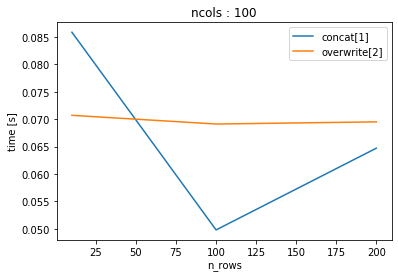

In [14]:
n_rows = 100
ncols_list = [10, 100, 200]
transpose=True
print_result(ncols_list, n_rows, transpose)

Mem. usage decreased to 0.1Mb:  75% reduction
Mem. usage decreased to 1.8Mb:  75% reduction
Mem. usage decreased to 3.7Mb:  75% reduction
Mem. usage decreased to 0.1Mb:  75% reduction
Mem. usage decreased to 1.8Mb:  75% reduction
Mem. usage decreased to 3.7Mb:  75% reduction


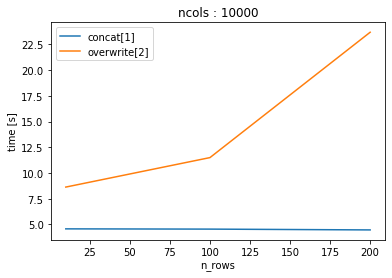

In [11]:
n_rows = 10000
ncols_list = [10, 100, 200]
transpose=True
print_result(ncols_list, n_rows, transpose)

Mem. usage decreased to 0.1Mb:  75% reduction
Mem. usage decreased to 1.8Mb:  75% reduction
Mem. usage decreased to 3.7Mb:  75% reduction
Mem. usage decreased to 0.1Mb:  75% reduction
Mem. usage decreased to 1.8Mb:  75% reduction
Mem. usage decreased to 3.7Mb:  75% reduction


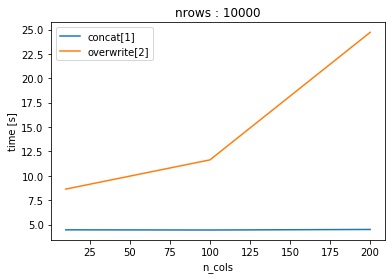

In [12]:
n_rows = 10000
ncols_list = [10, 100, 200]
transpose=False
print_result(ncols_list, n_rows, transpose)